In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append('..')
import pickle as pkl
from data_extraction_rxn_classification import *
from data_featurization import *
import json
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, cross_val_predict, GridSearchCV, ShuffleSplit, KFold
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import classification_report, precision_recall_fscore_support, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from pymatgen import Composition
import pprint as pp
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from collections import Counter
from xgboost import XGBClassifier
import shap
import time
import copy
from hyperopt import fmin, tpe, hp, STATUS_OK
from scipy.spatial.distance import cosine

In [3]:
all_elements = [Element.from_Z(i).symbol for i in range(1, 119)]

In [4]:
with open('../data/solid-state_dataset_20200713.json') as f:
    ss_data= json.load(f)
ss_reactions = ss_data["reactions"]
ss_extracted, ss_precursor_nomenclature = extract_solidstate(ss_reactions)
ss_no_duplicates = remove_duplicates(ss_extracted)

Returning extracted data of 26787/31782 reactions.
After removing duplicates, remaining extracted data contains 16010/26787 reactions.


In [5]:
with open('../data/sol-gel_dataset_20200713.json') as f:
    sg_data= json.load(f)
sg_reactions = sg_data["reactions"]
sg_extracted, sg_precursor_nomenclature = extract_solgel(sg_reactions)
sg_no_duplicates = remove_duplicates(sg_extracted)

Returning extracted data of 6854/9518 reactions.
After removing duplicates, remaining extracted data contains 4146/6854 reactions.


In [6]:
with open('../data/solution-synthesis_dataset_2021-8-5.json') as f:
    sol_data= json.load(f)
sol_extracted, sol_precursor_nomenclature = extract_solution(sol_data)
sol_no_duplicates = remove_duplicates(sol_extracted, solution=True)

No electronegativity for Hs. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.


Returning extracted data of 14116/35675 reactions.
After removing duplicates, remaining extracted data contains 5686/14116 reactions.


# Remove or deal with all reactions that take place in more than one category

In [7]:
all_three = []
ss_sg = []
sol_sg = []
for sg_rxn in sg_no_duplicates:
    found_ss_rxn = None
    found_sol_rxn = None
    for ss_rxn in ss_no_duplicates:
        if sg_rxn['target'] == ss_rxn['target'] and set(sg_rxn['precursors']) == set(ss_rxn['precursors']):
            found_ss_rxn = ss_rxn
            break
    for sol_rxn in sol_no_duplicates:
        if sg_rxn['target'] == sol_rxn['target'] and set(sg_rxn['precursors']) == set(sol_rxn['precursors']):
            found_sol_rxn = sol_rxn
            break
    # count prec/hyd dois
    if found_sol_rxn:
        prec_dois = []
        hyd_dois = []
        for i in range(len(sol_rxn['type'])):
            if sol_rxn['type'][i] == 'precipitation':
                prec_dois.append(sol_rxn['DOIs'][i])
            else:
                hyd_dois.append(sol_rxn['DOIs'][i])
    if found_ss_rxn and found_sol_rxn:

        all_three.append({
        'target': sg_rxn['target'],
        'precursors': sg_rxn['precursors'],
        'ss_dois': ss_rxn['DOIs'],
        'sg_dois': sg_rxn['DOIs'],
        'sol_dois': sol_rxn['DOIs'],
        'prec_dois': prec_dois,
        'hyd_dois': hyd_dois,
        'type': sol_rxn['type']
    })
    elif found_ss_rxn:
        ss_sg.append({
            'target': sg_rxn['target'],
            'precursors': sg_rxn['precursors'],
            'ss_dois': ss_rxn['DOIs'],
            'sg_dois': sg_rxn['DOIs'],
            'sol_dois': []
        })
    elif found_sol_rxn:
        sol_sg.append({
        'target': sg_rxn['target'],
        'precursors': sg_rxn['precursors'],
        'ss_dois': [],
        'sg_dois': sg_rxn['DOIs'],
        'sol_dois': sol_rxn['DOIs'],
        'prec_dois': prec_dois,
        'hyd_dois': hyd_dois,
        'type': sol_rxn['type']
        })

In [8]:
ss_sol = []
for ss_rxn in ss_no_duplicates:
    found_sg_rxn = None
    found_sol_rxn = None
    for sg_rxn in sg_no_duplicates:
        if sg_rxn['target'] == ss_rxn['target'] and set(sg_rxn['precursors']) == set(ss_rxn['precursors']):
            found_sg_rxn = sg_rxn
            break
    for sol_rxn in sol_no_duplicates:
        if sg_rxn['target'] == sol_rxn['target'] and set(sg_rxn['precursors']) == set(sol_rxn['precursors']):
            found_sol_rxn = sol_rxn
            break
    # count prec/hyd dois
    if found_sol_rxn:
        prec_dois = []
        hyd_dois = []
        for i in range(len(sol_rxn['type'])):
            if sol_rxn['type'][i] == 'precipitation':
                prec_dois.append(sol_rxn['DOIs'][i])
            else:
                hyd_dois.append(sol_rxn['DOIs'][i])
    if found_sg_rxn and found_sol_rxn:
        continue
    elif found_sg_rxn:
        continue
    elif found_sol_rxn:
        ss_sol.append({
        'target': ss_rxn['target'],
        'precursors': ss_rxn['precursors'],
        'ss_dois': ss_rxn['DOIs'],
        'sg_dois': [],
        'sol_dois': sol_rxn['DOIs'],
        'prec_dois': prec_dois,
        'hyd_dois': hyd_dois,
        'type': sol_rxn['type']
        })

In [9]:
print(len(ss_sol), len(ss_sg), len(sol_sg), len(all_three))

0 140 212 31


In [10]:
only_sg_rxns = []
only_ss_rxns = []
only_sol_rxns = []
for sg_rxn in sg_no_duplicates:
    found = False
    for dup_rxn in ss_sg + all_three + sol_sg:
        if sg_rxn['target'] == dup_rxn['target'] and set(sg_rxn['precursors']) == set(dup_rxn['precursors']):
            found = True
    if not found:
        only_sg_rxns.append(sg_rxn)
    
for ss_rxn in ss_no_duplicates:
    found = False
    for dup_rxn in ss_sg + all_three + ss_sol:
        if ss_rxn['target'] == dup_rxn['target'] and set(ss_rxn['precursors']) == set(dup_rxn['precursors']):
            found = True
    if not found:
        only_ss_rxns.append(ss_rxn)
for sol_rxn in sol_no_duplicates:
    found = False
    for dup_rxn in sol_sg + all_three + ss_sol:
        if sol_rxn['target'] == dup_rxn['target'] and set(sol_rxn['precursors']) == set(dup_rxn['precursors']):
            found = True
    if not found:
        only_sol_rxns.append(sol_rxn)

In [11]:
print(len(sg_no_duplicates), len(ss_no_duplicates), len(sol_no_duplicates))
print(len(only_sg_rxns), len(only_ss_rxns), len(only_sol_rxns))

4146 16010 5686
3763 15839 5443


In [12]:
only_prec_rxns = []
only_hyd_rxns = []
for rxn in only_sol_rxns:
    ct = Counter(rxn['type'])
    if ct['precipitation'] <= ct['hydrothermal']:
        only_hyd_rxns.append(rxn)
    else:
        only_prec_rxns.append(rxn)

In [13]:
print(len(only_hyd_rxns), len(only_prec_rxns))

3324 2119


In [14]:
# allocate ambiguous rxns based on doi presence
for rxn in ss_sg:
    if len(rxn['sg_dois']) > len(rxn['ss_dois']):
        only_sg_rxns.append(rxn)
    else:
        only_ss_rxns.append(rxn)
for rxn in sol_sg:
    if len(rxn['sol_dois']) > len(rxn['sg_dois']):
        ct = Counter(rxn['type'])
        if ct['precipitation'] <= ct['hydrothermal']:
            only_hyd_rxns.append(rxn)
        else:
            only_prec_rxns.append(rxn)
    else:
        only_sg_rxns.append(rxn)
for rxn in all_three:
    if len(rxn['ss_dois']) >= len(rxn['sg_dois']) and len(rxn['ss_dois']) >= len(rxn['sol_dois']):
        only_ss_rxns.append(rxn)
    elif len(rxn['sg_dois']) >= len(rxn['ss_dois']) and len(rxn['sg_dois']) >= len(rxn['sol_dois']):
        only_sg_rxns.append(rxn)
    else:
        ct = Counter(rxn['type'])
        if ct['precipitation'] <= ct['hydrothermal']:
            only_hyd_rxns.append(rxn)
        else:
            only_prec_rxns.append(rxn)

In [15]:
# change precursor functional groups back
for rxn in only_ss_rxns:
    for i in range(len(rxn['precursors'])):
        rxn['precursors'][i] = ss_precursor_nomenclature[Composition(rxn['precursors'][i])]
for rxn in only_sg_rxns:
    for i in range(len(rxn['precursors'])):
        rxn['precursors'][i] = sg_precursor_nomenclature[Composition(rxn['precursors'][i])]
for rxn in only_hyd_rxns:
    for i in range(len(rxn['precursors'])):
        rxn['precursors'][i] = sol_precursor_nomenclature[Composition(rxn['precursors'][i])]
for rxn in only_prec_rxns:
    for i in range(len(rxn['precursors'])):
        rxn['precursors'][i] = sol_precursor_nomenclature[Composition(rxn['precursors'][i])]

In [16]:
# Onehot precursor functional groups

In [17]:
m_anions = ['H2PO4', 'HPO4', 'HCO3', 'HSO4', 'HSO3', 'C2O4']
d_anions = ['CO3', 'PO4', 'PO3', 'OH', 'NH4', 'NO3', 'NO2', 'SO4', 'SO3', 'CN'] #BO3, VO4, NH2
s_anions = ['F', 'B', 'P', 'Cl', 'F', 'Br', 'S', 'N', 'O', 'C']
ions = m_anions + d_anions + s_anions + ['Org'] + ['Ac'] + ['Elem'] + ['Other']

In [18]:
len(ions)

30

In [19]:
ss_anion_dict = {x: [] for x in ions}
for rxn in only_ss_rxns:
    anion_dict = {x: [] for x in ions}
    for prec in rxn['precursors']:
        found = False
        # check acetate first
        if 'CH3COO' in prec:
            anion_dict['Ac'].append(prec)
            found = True
        # check organic
        elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
            anion_dict['Org'].append(prec)
            found = True
        else:
            for anion in ions:
                # special check for elemental anions
                if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                    anion_dict[anion].append(prec)
                    found = True
                    break
        if not found:
            # check if precursor is elemental
            if prec in all_elements:
                anion_dict['Elem'].append(prec)
            else:
                anion_dict['Other'].append(prec)
    # create fractional embedding
    for key in anion_dict:
        ss_anion_dict[key].append(len(anion_dict[key]) / len(rxn['precursors']))
        

In [20]:
sg_anion_dict = {x: [] for x in ions}
for rxn in only_sg_rxns:
    anion_dict = {x: [] for x in ions}
    for prec in rxn['precursors']:
        found = False
        # check acetate first
        if 'CH3COO' in prec:
            anion_dict['Ac'].append(prec)
            found = True
        # check organic
        elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
            anion_dict['Org'].append(prec)
            found = True
        else:
            for anion in ions:
                # special check for elemental anions
                if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                    anion_dict[anion].append(prec)
                    found = True
                    break
        if not found:
            # check if precursor is elemental
            if prec in all_elements:
                anion_dict['Elem'].append(prec)
            else:
                anion_dict['Other'].append(prec)
    # create fractional embedding
    for key in anion_dict:
        sg_anion_dict[key].append(len(anion_dict[key]) / len(rxn['precursors']))
        

In [21]:
hyd_anion_dict = {x: [] for x in ions}
for rxn in only_hyd_rxns:
    anion_dict = {x: [] for x in ions}
    for prec in rxn['precursors']:
        found = False
        # check acetate first
        if 'CH3COO' in prec:
            anion_dict['Ac'].append(prec)
            found = True
        # check organic
        elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
            anion_dict['Org'].append(prec)
            found = True
        else:
            for anion in ions:
                # special check for elemental anions
                if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                    anion_dict[anion].append(prec)
                    found = True
                    break
        if not found:
            # check if precursor is elemental
            if prec in all_elements:
                anion_dict['Elem'].append(prec)
            else:
                anion_dict['Other'].append(prec)
    # create fractional embedding
    for key in anion_dict:
        hyd_anion_dict[key].append(len(anion_dict[key]) / len(rxn['precursors']))
        

In [22]:
prec_anion_dict = {x: [] for x in ions}
for rxn in only_prec_rxns:
    anion_dict = {x: [] for x in ions}
    for prec in rxn['precursors']:
        found = False
        # check acetate first
        if 'CH3COO' in prec:
            anion_dict['Ac'].append(prec)
            found = True
        # check organic
        elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
            anion_dict['Org'].append(prec)
            found = True
        else:
            for anion in ions:
                # special check for elemental anions
                if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                    anion_dict[anion].append(prec)
                    found = True
                    break
        if not found:
            # check if precursor is elemental
            if prec in all_elements:
                anion_dict['Elem'].append(prec)
            else:
                anion_dict['Other'].append(prec)
    # create fractional embedding
    for key in anion_dict:
        prec_anion_dict[key].append(len(anion_dict[key]) / len(rxn['precursors']))
        

In [23]:
print(len(ss_anion_dict['O']), len(sg_anion_dict['O']), len(hyd_anion_dict['O']), len(prec_anion_dict['O']))

15937 3979 3362 2150


# add in melting point features

In [24]:
with open('data/full_mp.json', 'r') as f:
    full_mp = json.load(f)

In [25]:
full_mp = {Composition(x): full_mp[x] for x in full_mp}

In [26]:
full_mp_median = np.median(list(full_mp.values()))

In [27]:
# add MP features
for new_result in only_ss_rxns:
    # precursor MP features
    melting_points = [full_mp.get(Composition(x), full_mp_median) for x in new_result["precursors"]]
    new_result['feature_exp_min_mp'] = min(melting_points)
    new_result['feature_exp_max_mp'] = max(melting_points)
    new_result['feature_exp_mean_mp'] = np.mean(melting_points)
    new_result['feature_exp_div_mp'] = max(melting_points) - min(melting_points)
for new_result in only_sg_rxns:
    # precursor MP features
    melting_points = [full_mp.get(Composition(x), full_mp_median) for x in new_result["precursors"]]
    new_result['feature_exp_min_mp'] = min(melting_points)
    new_result['feature_exp_max_mp'] = max(melting_points)
    new_result['feature_exp_mean_mp'] = np.mean(melting_points)
    new_result['feature_exp_div_mp'] = max(melting_points) - min(melting_points)
for new_result in only_hyd_rxns:
    # precursor MP features
    melting_points = [full_mp.get(Composition(x), full_mp_median) for x in new_result["precursors"]]
    new_result['feature_exp_min_mp'] = min(melting_points)
    new_result['feature_exp_max_mp'] = max(melting_points)
    new_result['feature_exp_mean_mp'] = np.mean(melting_points)
    new_result['feature_exp_div_mp'] = max(melting_points) - min(melting_points)
for new_result in only_prec_rxns:
    # precursor MP features
    melting_points = [full_mp.get(Composition(x), full_mp_median) for x in new_result["precursors"]]
    new_result['feature_exp_min_mp'] = min(melting_points)
    new_result['feature_exp_max_mp'] = max(melting_points)
    new_result['feature_exp_mean_mp'] = np.mean(melting_points)
    new_result['feature_exp_div_mp'] = max(melting_points) - min(melting_points)

In [28]:
target_names = [x["target"] for x in only_ss_rxns] + [x["target"] for x in only_sg_rxns] + [x["target"] for x in only_hyd_rxns] + [x["target"] for x in only_prec_rxns]
labels = np.concatenate([np.ones(shape=len(only_ss_rxns)), np.zeros(shape=len(only_sg_rxns)), np.full(shape=len(only_hyd_rxns)+len(only_prec_rxns), fill_value=2)])
labels_multiclass = np.concatenate([np.ones(shape=len(only_ss_rxns)), np.zeros(shape=len(only_sg_rxns)), np.full(shape=len(only_hyd_rxns), fill_value=2), np.full(shape=len(only_prec_rxns), fill_value=3)])
precursors = [x["precursors"] for x in only_ss_rxns] + [x["precursors"] for x in only_sg_rxns] + [x["precursors"] for x in only_hyd_rxns] + [x["precursors"] for x in only_prec_rxns]
feature_exp_min_mp = [x['feature_exp_min_mp'] for x in only_ss_rxns] + [x['feature_exp_min_mp'] for x in only_sg_rxns] + [x['feature_exp_min_mp'] for x in only_hyd_rxns] + [x['feature_exp_min_mp'] for x in only_prec_rxns]
feature_exp_max_mp = [x['feature_exp_max_mp'] for x in only_ss_rxns] + [x['feature_exp_max_mp'] for x in only_sg_rxns] + [x['feature_exp_max_mp'] for x in only_hyd_rxns] + [x['feature_exp_min_mp'] for x in only_prec_rxns]
feature_exp_mean_mp = [x['feature_exp_mean_mp'] for x in only_ss_rxns] + [x['feature_exp_mean_mp'] for x in only_sg_rxns] + [x['feature_exp_mean_mp'] for x in only_hyd_rxns] + [x['feature_exp_min_mp'] for x in only_prec_rxns]
feature_exp_div_mp = [x['feature_exp_div_mp'] for x in only_ss_rxns] + [x['feature_exp_div_mp'] for x in only_sg_rxns] + [x['feature_exp_div_mp'] for x in only_hyd_rxns] + [x['feature_exp_min_mp'] for x in only_prec_rxns]

In [29]:
# get dois
dois = []
ss_dois = []
sg_dois = []
prec_dois = []
hyd_dois = []
for entry in only_ss_rxns + only_sg_rxns + only_hyd_rxns + only_prec_rxns:
    if 'DOIs' in entry:
        # wasn't a shared entry, store in appropriate column
        dois.append(entry['DOIs'])
        ss_dois.append([])
        sg_dois.append([])
        prec_dois.append([])
        hyd_dois.append([])
    else:
        # append empty to dois
        dois.append([])
        # shared, append
        if 'ss_dois' in entry:
            ss_dois.append(entry['ss_dois'])
        else:
            ss_dois.append([])
        if 'sg_dois' in entry:
            sg_dois.append(entry['sg_dois'])
        else:
            sg_dois.append([])
        if 'prec_dois' in entry:
            prec_dois.append(entry['prec_dois'])
        else:
            prec_dois.append([])
        if 'hyd_dois' in entry:
            hyd_dois.append(entry['hyd_dois'])
        else:
            hyd_dois.append([])
        
        

In [30]:
print(len(dois), len(ss_dois), len(sg_dois), len(prec_dois), len(hyd_dois))

25428 25428 25428 25428 25428


In [31]:
feature_calculators = MultipleFeaturizer([
    cf.ElementFraction()
])

# feature_calculators = MultipleFeaturizer([
#     cf.Stoichiometry(),
#     cf.ElementProperty.from_preset("magpie"),
#     cf.ValenceOrbital(props=["avg"]),
#     cf.IonProperty(fast=True) 
# ])


In [32]:
data = pd.DataFrame()
data["targets"] = target_names
data["precursors"] = precursors
data["labels"] = labels
data["labels_multiclass"] = labels_multiclass

df = StrToComposition(target_col_id="composition_obj").featurize_dataframe(data, "targets", ignore_errors=True)
df = feature_calculators.featurize_dataframe(df, col_id="composition_obj", ignore_errors = True)

for key in ss_anion_dict:
    df[key + "_prec"] = ss_anion_dict[key] + sg_anion_dict[key] + hyd_anion_dict[key] + prec_anion_dict[key]

In [33]:
feature_exp_min_mp = [x['feature_exp_min_mp'] for x in only_ss_rxns] + [x['feature_exp_min_mp'] for x in only_sg_rxns] + [x['feature_exp_min_mp'] for x in only_hyd_rxns] + [x['feature_exp_min_mp'] for x in only_prec_rxns]
feature_exp_max_mp = [x['feature_exp_max_mp'] for x in only_ss_rxns] + [x['feature_exp_max_mp'] for x in only_sg_rxns] + [x['feature_exp_max_mp'] for x in only_hyd_rxns] + [x['feature_exp_max_mp'] for x in only_prec_rxns]
feature_exp_mean_mp = [x['feature_exp_mean_mp'] for x in only_ss_rxns] + [x['feature_exp_mean_mp'] for x in only_sg_rxns] + [x['feature_exp_mean_mp'] for x in only_hyd_rxns] + [x['feature_exp_mean_mp'] for x in only_prec_rxns]
feature_exp_div_mp = [x['feature_exp_div_mp'] for x in only_ss_rxns] + [x['feature_exp_div_mp'] for x in only_sg_rxns] + [x['feature_exp_div_mp'] for x in only_hyd_rxns] + [x['feature_exp_div_mp'] for x in only_prec_rxns]

In [34]:
df['feature_exp_min_mp'] = feature_exp_min_mp
df['feature_exp_max_mp'] = feature_exp_max_mp
df['feature_exp_mean_mp'] = feature_exp_mean_mp
df['feature_exp_div_mp'] = feature_exp_div_mp

In [35]:
df['dois'] = dois
df['ss_dois'] = ss_dois
df['sg_dois'] = sg_dois
df['hyd_dois'] = hyd_dois
df['prec_dois'] = prec_dois

In [36]:
lens = [len(x) for x in df["precursors"].values]
Counter(lens)

Counter({2: 8879, 3: 9915, 4: 5122, 5: 1166, 6: 275, 8: 17, 7: 53, 10: 1})

In [37]:
df = df[df.precursors.str.len() <= 5]

In [40]:
df.columns

Index(['targets', 'precursors', 'labels', 'labels_multiclass',
       'composition_obj', 'H', 'He', 'Li', 'Be', 'B',
       ...
       'Other_prec', 'feature_exp_min_mp', 'feature_exp_max_mp',
       'feature_exp_mean_mp', 'feature_exp_div_mp', 'dois', 'ss_dois',
       'sg_dois', 'hyd_dois', 'prec_dois'],
      dtype='object', length=146)

In [126]:
omit_columns = ['targets', 'precursors', 'labels', 'labels_multiclass', 'composition_obj', 'dois', 'ss_dois', 'sg_dois', 'hyd_dois', 'prec_dois']
X_columns = [x for x in df.columns if x not in omit_columns]
y_column = 'labels_multiclass'
X_df = df[X_columns]
X = X_df.values
y = df[y_column].values
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))
y = y.astype(int)
# X, y = shuffle(X, y, random_state=42)

Shape of X: (25082, 136)
Shape of y: (25082,)


# Hyperparameter tuning and model metrics

In [127]:
# hyperparameter tuning
# XGB hyperparameters

n_estimators = [25, 50, 100, 200]
max_depth=[3, 6, 9]
learning_rate = [0.1, 0.2, 0.3]
colsample_bytree = [0.6, 0.8, 1]
colsample_bylevel = [0.6, 0.8, 1]
min_child_weight = [1, 2, 3]
subsample = [0.7, 0.9, 1]

orig_parameters = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'learning_rate': learning_rate,
              'colsample_bytree': colsample_bytree,
              'colsample_bylevel': colsample_bylevel,
              'min_child_weight': min_child_weight,
              'subsample': subsample
}

# Create the random grid
parameters = {'n_estimators': hp.choice('n_estimators', n_estimators),
              'max_depth': hp.choice('max_depth', max_depth),
              'learning_rate': hp.choice('learning_rate', learning_rate),
              'colsample_bytree': hp.choice('colsample_bytree', colsample_bytree),
              'colsample_bylevel': hp.choice('colsample_bylevel', colsample_bylevel),
              'min_child_weight': hp.choice('min_child_weight', min_child_weight),
              'subsample': hp.choice('subsample', subsample)
}

def objective(parameters):
    clf = XGBClassifier(
        n_estimators=parameters['n_estimators'],
        max_depth=parameters['max_depth'],
        learning_rate=parameters['learning_rate'],
        colsample_bytree=parameters['colsample_bytree'],
        colsample_bylevel=parameters['colsample_bylevel'],
        min_child_weight=parameters['min_child_weight'],
        subsample=parameters['subsample'],
        objective='multi:softmax', 
        num_class=4
    )
    sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_curr)
    clf.fit(X_train_curr, y_train_curr, eval_metric='mlogloss', sample_weight=sample_weights)
    
    y_pred_val = clf.predict(X_val)
    curr_f1 = f1_score(y_val, y_pred_val, average='micro')
    
    return {'loss': -curr_f1, 'status': STATUS_OK}
    


In [179]:
# hyperparameter tune for 1 train/test split

# create train and test, 90/10 split
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, y, df, test_size=0.10, shuffle=True, random_state=84)

# create val split for this cv split from train
# 72/18/10 split
X_train_curr, X_val, y_train_curr, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

best_parameters = fmin(fn=objective, space=parameters, algo=tpe.suggest, max_evals=100)

# convert index to value
for key in best_parameters:
    best_parameters[key] = orig_parameters[key][best_parameters[key]]

# get best estimator and get train and test predictions

clf_best = XGBClassifier(
    n_estimators=best_parameters['n_estimators'],
    max_depth=best_parameters['max_depth'],
    learning_rate=best_parameters['learning_rate'],
    colsample_bytree=best_parameters['colsample_bytree'],
    colsample_bylevel=best_parameters['colsample_bylevel'],
    min_child_weight=best_parameters['min_child_weight'],
    subsample=best_parameters['subsample'],
    objective='multi:softmax', 
    num_class=4
)

sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
clf_best.fit(X_train, y_train, eval_metric='mlogloss', sample_weight=sample_weights)

y_pred_train = clf_best.predict(X_train)
y_pred_test = clf_best.predict(X_test)
y_pred_test_proba = clf_best.predict_proba(X_test)


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



100%|██████████| 100/100 [08:02<00:00,  4.83s/trial, best loss: -0.8372093023255814]


In [180]:
# test performance - F1 micro optimized
class_names=['sol-gel', 'solid-state', 'hydrothermal', 'precipitation']
print(classification_report(y_test, y_pred_test, target_names=class_names))

               precision    recall  f1-score   support

      sol-gel       0.76      0.81      0.78       383
  solid-state       0.95      0.92      0.94      1577
 hydrothermal       0.64      0.69      0.67       304
precipitation       0.61      0.58      0.60       245

     accuracy                           0.85      2509
    macro avg       0.74      0.75      0.75      2509
 weighted avg       0.85      0.85      0.85      2509



In [181]:
# test performance - F1 macro optimized
class_names=['sol-gel', 'solid-state', 'hydrothermal', 'precipitation']
print(classification_report(y_test, y_pred_test, target_names=class_names))

               precision    recall  f1-score   support

      sol-gel       0.76      0.81      0.78       383
  solid-state       0.95      0.92      0.94      1577
 hydrothermal       0.64      0.69      0.67       304
precipitation       0.61      0.58      0.60       245

     accuracy                           0.85      2509
    macro avg       0.74      0.75      0.75      2509
 weighted avg       0.85      0.85      0.85      2509



# Look at precursor anion dicts

# SHAP metrics and cosine similarity

In [182]:
explainer = shap.TreeExplainer(clf_best)
shap_values_test = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [183]:
# make feature names for display
feature_labels = []
for label in X_columns:
    if 'prec' in label:
        label = label.replace("_", " ")
        feature_labels.append(label + "ursor")
    elif 'feature_exp' in label:
        feature_labels.append(label.replace("feature_exp_", "").replace("mp", "MP").replace("div", "std_dev").replace("_", " ").replace("max", "Max").replace("mean", "Mean").replace("std", "Std").replace("min", "Min"))
    else:
        label = label.replace("_", " ")
        feature_labels.append(label)

# Case studies

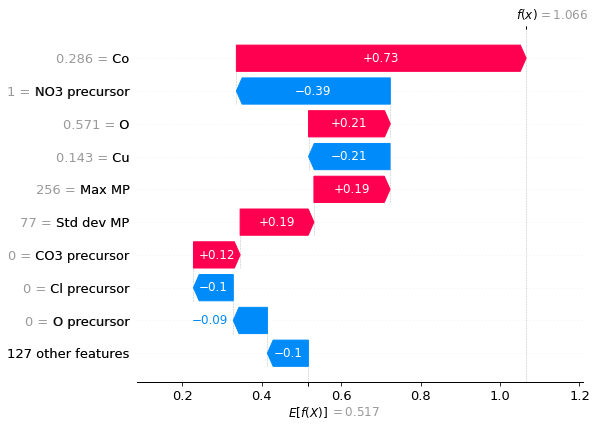

In [232]:
fig, ax = plt.subplots()
which_class = 2
row = 1424
# ax.set_title("Solid-state", fontsize=18)
shap.waterfall_plot(shap.Explanation(values=shap_values_test[int(which_class)][row], 
                                         base_values=explainer.expected_value[int(which_class)], 
                                         data=X_test[row],  # added this line
                                         feature_names=feature_labels))
fig.tight_layout()
fig.savefig('figures/no3_case_study.png', dpi=150)

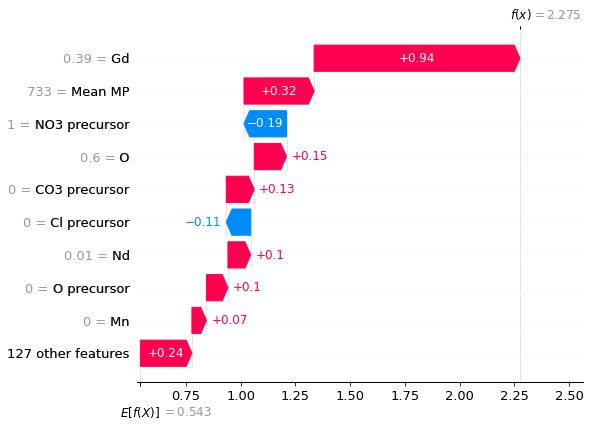

In [230]:
fig, ax = plt.subplots()
which_class = 3
row = 2312
# ax.set_title("Solid-state", fontsize=18)
shap.waterfall_plot(shap.Explanation(values=shap_values_test[int(which_class)][row], 
                                         base_values=explainer.expected_value[int(which_class)], 
                                         data=X_test[row],  # added this line
                                         feature_names=feature_labels))
fig.tight_layout()
fig.savefig('figures/no3_case_study_2.png', dpi=150)

# Element fraction analysis

In [75]:
# count how many targets contain oxygen
all_tars = list(df['targets'].values)
multi_class_labels = list(df['labels_multiclass'].values)
cont_o, not_cont_o = [], []
cont_o_labels, not_cont_o_labels = [], []
for tar, label in zip(all_tars, multi_class_labels):
    comp = Composition(tar)
    els = list(comp.get_el_amt_dict().keys())
    if "O" in els:
        cont_o.append(tar)
        cont_o_labels.append(label)
    else:
        not_cont_o.append(tar)
        not_cont_o_labels.append(label)

In [76]:
print(len(cont_o), len(not_cont_o), len(all_tars))
print(len(cont_o)/len(all_tars))

22098 2984 25082
0.8810302208755283


In [77]:
# plot fraction of containing oxygen for each
for i in range(4):
    print(pd.Series(cont_o_labels).value_counts()[i] / pd.Series(df['labels_multiclass']).value_counts()[i])

0.9735449735449735
0.9104
0.6946268656716418
0.7867165575304023


In [78]:
# separate by rxn class
o_df = pd.concat([df[df["labels_multiclass"]==0]["O"], df[df["labels_multiclass"]==1]["O"], df[df["labels_multiclass"]==2]["O"], df[df["labels_multiclass"]==3]["O"]], axis=1, ignore_index=True)

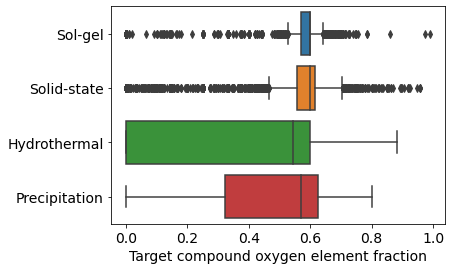

In [220]:
fig, ax = plt.subplots()
sns.boxplot(data=o_df, orient="h")
ax.set_xlabel('Target compound oxygen element fraction', fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_yticklabels(['Sol-gel', 'Solid-state', 'Hydrothermal', 'Precipitation'], fontsize=14)
plt.show()
fig.tight_layout()
fig.savefig('figures/oxygen_element_fraction_distribution.png', dpi=150)

In [43]:
# dummy classifier performance
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)
print(classification_report(y_test, dummy_pred, target_names=class_names))

               precision    recall  f1-score   support

      sol-gel       0.15      0.16      0.15       368
  solid-state       0.62      0.62      0.62      1589
 hydrothermal       0.13      0.11      0.12       353
precipitation       0.08      0.09      0.08       199

     accuracy                           0.44      2509
    macro avg       0.25      0.25      0.25      2509
 weighted avg       0.44      0.44      0.44      2509



In [44]:
# dummy classifier performance
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)
print(classification_report(y_test, dummy_pred, target_names=class_names))

               precision    recall  f1-score   support

      sol-gel       0.00      0.00      0.00       368
  solid-state       0.63      1.00      0.78      1589
 hydrothermal       0.00      0.00      0.00       353
precipitation       0.00      0.00      0.00       199

     accuracy                           0.63      2509
    macro avg       0.16      0.25      0.19      2509
 weighted avg       0.40      0.63      0.49      2509



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [46]:
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, y, df, test_size=0.10, shuffle=True, random_state=42)

In [48]:
# dummy classifier performance - 3 class
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)
print(classification_report(y_test, dummy_pred, target_names=["solid-state", "sol-gel", "solution"]))

              precision    recall  f1-score   support

 solid-state       0.13      0.14      0.13       368
     sol-gel       0.64      0.63      0.64      1589
    solution       0.20      0.20      0.20       552

    accuracy                           0.47      2509
   macro avg       0.33      0.32      0.32      2509
weighted avg       0.47      0.47      0.47      2509



In [50]:
# dummy classifier performance - 3 class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)
print(classification_report(y_test, dummy_pred, target_names=["solid-state", "sol-gel", "solution"]))

              precision    recall  f1-score   support

 solid-state       0.00      0.00      0.00       368
     sol-gel       0.63      1.00      0.78      1589
    solution       0.00      0.00      0.00       552

    accuracy                           0.63      2509
   macro avg       0.21      0.33      0.26      2509
weighted avg       0.40      0.63      0.49      2509



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
